In [8]:
#Importer les packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score,precision_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier,plot_tree

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings("ignore")



In [9]:
#Importer la Base de données
df=pd.read_csv('train_u6lujuX_CVtuZ9i.csv')
df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


In [10]:
# Voir les valeurs manquantes
df.isnull().sum().sort_values(ascending=False)

Credit_History       50
Self_Employed        32
LoanAmount           22
Dependents           15
Loan_Amount_Term     14
Gender               13
Married               3
Loan_ID               0
Education             0
ApplicantIncome       0
CoapplicantIncome     0
Property_Area         0
Loan_Status           0
dtype: int64

In [11]:
#voir les statistiques de la BD
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


# 1) Data Preprocessing && Data Cleaning

In [12]:
# On divise le dataset en 2 BD( une pour les valeurs catégoriques et l'autre pour les valeurs numériques)
cat_data=[]
num_data=[]
for i,c in enumerate(df.dtypes):
  if c==object:
    cat_data.append(df.iloc[:,i])
  else:
    num_data.append(df.iloc[:,i])
#Transformer les listes en BD à l'aide de pandas
cat_data=pd.DataFrame(cat_data).transpose()
num_data=pd.DataFrame(num_data).transpose()

cat_data



,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,Urban,Y
4,LP001008,Male,No,0,Graduate,No,Urban,Y
...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,Urban,Y


In [13]:
#Renseigenr les valeurs manquantes
#Pour les variables catégoriques on va remplacer par les valeurs qui se répetent le plus
cat_data=cat_data.apply(lambda x:x.fillna(x.value_counts().index[0]))
cat_data.isnull().sum().any()

False

In [14]:
# Pour les variables numériques on va remplacer les valeurs manquantes par la valeur précedente de la meme colonne
num_data.fillna(method='bfill',inplace=True)
num_data.isnull().sum().any()


False

In [15]:
# Remplacer dans la colonne target les valeurs { Y,N} par {1,0}
target_value={'Y':1,'N':0}
target=cat_data['Loan_Status']
cat_data.drop('Loan_Status',axis=1,inplace=True)
target=target.map(target_value)
target


0      1
1      0
2      1
3      1
4      1
      ..
609    1
610    1
611    1
612    1
613    0
Name: Loan_Status, Length: 614, dtype: int64

In [16]:
#Normaliser la BD en transformant les valeurs catégoriques en des valeurs numériques
cat_data.replace({"Graduate": 1,"Not Graduate":0}, inplace = True)
cat_data.replace({"Male": 1,"Female":0}, inplace = True)
cat_data.replace({"Yes": 1,"No":0}, inplace = True)
    
cat_data

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area
0,LP001002,1,0,0,1,0,Urban
1,LP001003,1,1,1,1,0,Rural
2,LP001005,1,1,0,1,1,Urban
3,LP001006,1,1,0,0,0,Urban
4,LP001008,1,0,0,1,0,Urban
...,...,...,...,...,...,...,...
609,LP002978,0,0,0,1,0,Rural
610,LP002979,1,1,3+,1,0,Rural
611,LP002983,1,1,1,1,0,Urban
612,LP002984,1,1,2,1,0,Urban


In [17]:
# One Hot technique
Dependents = cat_data[["Dependents"]]
Dependents = pd.get_dummies(Dependents)

Property_Area = cat_data[["Property_Area"]]
Property_Area = pd.get_dummies(Property_Area)

# On concatène toutes ces donnés
cat_data = pd.concat([cat_data, Dependents, Property_Area], axis = 1)

# Supprime les colonnes du même nom que celles dans to_drop
to_drop = ['Dependents', 'Property_Area']
cat_data = cat_data.drop(columns=to_drop)

cat_data.head()


,Loan_ID,Gender,Married,Education,Self_Employed,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,LP001002,1,0,1,0,1,0,0,0,0,0,1
1,LP001003,1,1,1,0,0,1,0,0,1,0,0
2,LP001005,1,1,1,1,1,0,0,0,0,0,1
3,LP001006,1,1,0,0,1,0,0,0,0,0,1
4,LP001008,1,0,1,0,1,0,0,0,0,0,1


In [18]:
#Supprimer Loan ID
cat_data.drop('Loan_ID',axis=1,inplace=True)
              

In [19]:
# Concatener cat_Data et num_data et spécifier la colonne target


X=pd.concat([cat_data,num_data],axis=1)
y=target
X
#A ce niveau notre Base de données a été netoyée,elle est prête pour faire une analyse exploratoire

,Gender,Married,Education,Self_Employed,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
0,1,0,1,0,1,0,0,0,0,0,1,5849.0,0.0,128.0,360.0,1.0
1,1,1,1,0,0,1,0,0,1,0,0,4583.0,1508.0,128.0,360.0,1.0
2,1,1,1,1,1,0,0,0,0,0,1,3000.0,0.0,66.0,360.0,1.0
3,1,1,0,0,1,0,0,0,0,0,1,2583.0,2358.0,120.0,360.0,1.0
4,1,0,1,0,1,0,0,0,0,0,1,6000.0,0.0,141.0,360.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,0,0,1,0,1,0,0,0,1,0,0,2900.0,0.0,71.0,360.0,1.0
610,1,1,1,0,0,0,0,1,1,0,0,4106.0,0.0,40.0,180.0,1.0
611,1,1,1,0,0,1,0,0,0,0,1,8072.0,240.0,253.0,360.0,1.0
612,1,1,1,0,0,0,1,0,0,0,1,7583.0,0.0,187.0,360.0,1.0


# 2) Analyse Exploratoire des données


In [20]:
#La base de données utilisé pour EDA
df=pd.concat([cat_data,num_data,target],axis=1)

le pourcentage des crédits accordés est: 0.6872964169381107
le pourcentage des crédits non accordés est: 0.3127035830618892


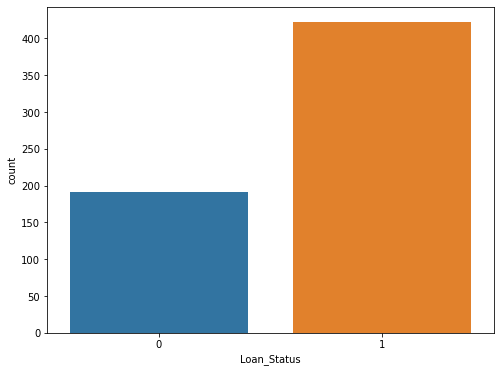

In [21]:
plt.figure(figsize=(8,6))
sns.countplot(target)
yes=target.value_counts().iloc[0]/len(target)
no=target.value_counts().iloc[1]/len(target)
print(f'le pourcentage des crédits accordés est: {yes}')
print(f'le pourcentage des crédits non accordés est: {no}')

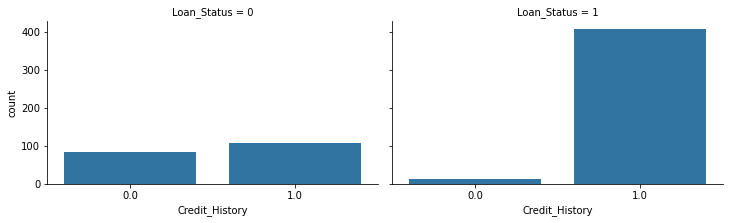

In [22]:
#Crédit History
grid=sns.FacetGrid(df,col='Loan_Status',size=3.2,aspect=1.6)
grid.map(sns.countplot,'Credit_History')

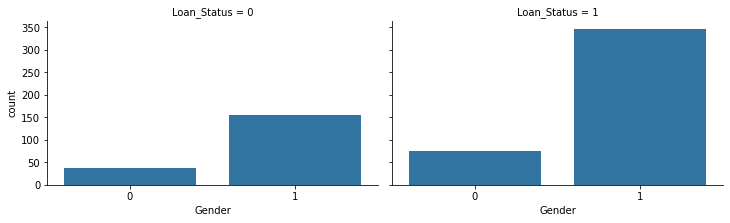

In [23]:
# Sexe
grid=sns.FacetGrid(df,col='Loan_Status',size=3.2,aspect=1.6)
grid.map(sns.countplot,'Gender')

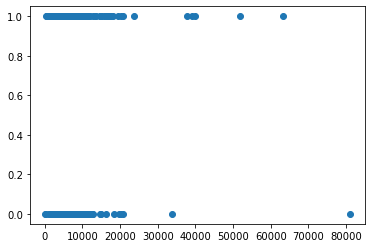

In [24]:
# Revenu du Demandeur
plt.scatter(df['ApplicantIncome'],df['Loan_Status'])

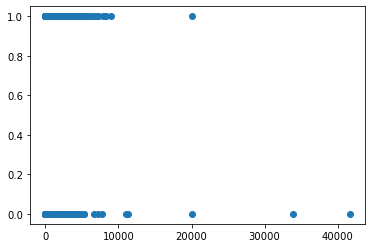

In [25]:
# Revenu se son conjoint
plt.scatter(df['CoapplicantIncome'],df['Loan_Status'])

In [26]:
df.groupby('Loan_Status').median()

,Gender,Married,Education,Self_Employed,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
Loan_Status,,,,,,,,,,,,,,,,
0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3833.5,268.0,132.5,360.0,1.0
1,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3812.5,1239.5,127.5,360.0,1.0


# 3)Algorithmes d'apprentissages ML 

In [27]:
# Diviser la base de données en une base de données test et d'entrainement
sss=StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
for train,test in sss.split(X,y):
    X_train,X_test=X.iloc[train],X.iloc[test]
    y_train,y_test=y.iloc[train],y.iloc[test]

print('X_train taille: ', X_train.shape)
print('X_test taille: ', X_test.shape)
print('y_train taille: ', y_train.shape)
print('y_test taille: ', y_test.shape)

X_train taille:  (491, 16)
X_test taille:  (123, 16)
y_train taille:  (491,)
y_test taille:  (123,)


In [28]:
#On applique trois algorithmes de ML (Logistic Regression,KNN,DecisionTree)


# 1-Logistic regression

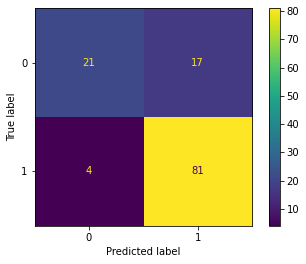

In [29]:
log_reg = LogisticRegression()
log_reg.fit(X_train,y_train)
pred =log_reg.predict(X_test)

cm = confusion_matrix(y_test, pred)

ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=log_reg.classes_).plot()


# 2-KNN


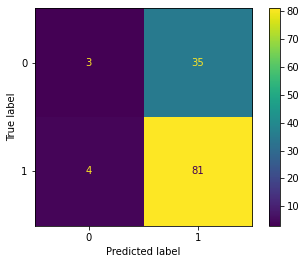

In [30]:
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier()
parameters = {'n_neighbors': np.arange(1, 20)}
knnCV = GridSearchCV(knn, parameters)

knnCV.fit(X_train,y_train)

knn = knnCV.best_estimator_
knn.fit(X_train, y_train)
pred =knn.predict(X_test)

cm = confusion_matrix(y_test, pred)
ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=log_reg.classes_).plot()


# 3-Decision Tree 

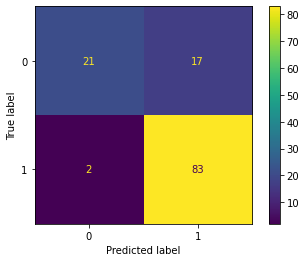

In [31]:

tree = DecisionTreeClassifier(random_state = 42)
parameters = {'max_depth': np.arange(1, 20)}
treeCV = GridSearchCV(tree, parameters)

treeCV.fit(X_train,y_train)

tree = treeCV.best_estimator_
tree.fit(X_train,y_train)
pred =tree.predict(X_test)

cm = confusion_matrix(y_test, pred)
ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=log_reg.classes_).plot()


In [32]:
#Calculons la performance pour plusieurs valeurs de X
models={
    'LogisticRegression':LogisticRegression(random_state=10),
    'KNeighborsClassifier':KNeighborsClassifier(),
    'DecisionTreeClassifier':DecisionTreeClassifier(max_depth=1,random_state=42)
}


#On définit une fonction qui permet d'evaluer plusieurs Models 
def train_test_eval(models,X_train,y_train,X_test,y_test):
  for name,model in models.items():
    print(name,':')
    model.fit(X_train,y_train)
    print(f'accuracy-score:{accuracy_score(y_test,model.predict(X_test))}')
    print(f'precision_score:{precision_score(y_test,model.predict(X_test))}')
    print('-'*30)

train_test_eval(models,X_train,y_train,X_test,y_test)


LogisticRegression :
accuracy-score:0.8292682926829268
precision_score:0.826530612244898
------------------------------
KNeighborsClassifier :
accuracy-score:0.6504065040650406
precision_score:0.71875
------------------------------
DecisionTreeClassifier :
accuracy-score:0.8455284552845529
precision_score:0.83
------------------------------


In [33]:
# Pour X2
X_2=X[['Credit_History','Education','CoapplicantIncome','Married']]
sss=StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
for train,test in sss.split(X_2,y):
  X_train,X_test=X_2.iloc[train],X_2.iloc[test]
  y_train,y_test=y.iloc[train],y.iloc[test]

print('X_train taille: ', X_train.shape)
print('X_test taille: ', X_test.shape)
print('y_train taille: ', y_train.shape)
print('y_test taille: ', y_test.shape)


X_train taille:  (491, 4)
X_test taille:  (123, 4)
y_train taille:  (491,)
y_test taille:  (123,)


In [34]:
train_test_eval(models,X_train,y_train,X_test,y_test)


LogisticRegression :
accuracy-score:0.8536585365853658
precision_score:0.8383838383838383
------------------------------
KNeighborsClassifier :
accuracy-score:0.6991869918699187
precision_score:0.7307692307692307
------------------------------
DecisionTreeClassifier :
accuracy-score:0.8455284552845529
precision_score:0.83
------------------------------
